In [ ]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

In [17]:
# import libraries
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import clear_output

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize and reshape

# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

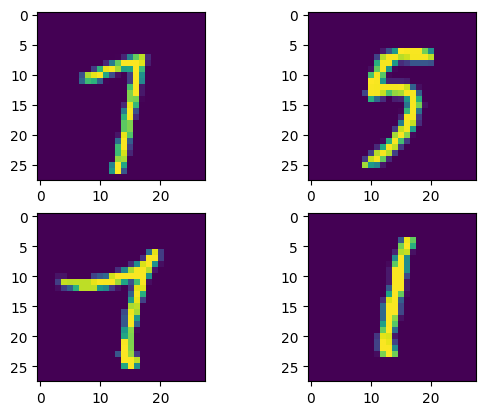

In [5]:
#View few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[21][:,:,0])

plt.subplot(222)
plt.imshow(x_train[210][:,:,0])

plt.subplot(223)
plt.imshow(x_train[2100][:,:,0])

plt.subplot(224)
plt.imshow(x_train[21000][:,:,0])
plt.show()

In [6]:
# BUILD THE MODEL

# # ENCODER
# Define 4 conv2D, flatten and then dense layers

latent_dim = 2 # Define two dimensional latent space
               # That means encoded data will be two dimensional

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) # Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
# Use these to sample random variables in latent space to which inputs are mapped.
z_mu = Dense(latent_dim, name='latent_mu')(x)   # Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  # Standart deviation of encoded input

# REPARAMETERIZATION
# Define sampling function to sample from the distribution
# Reparameterize samples into the shape of: mu + sigma squared x eps
# This allows gradient descent to work.
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the lambda custom layer we are adding for gradient descent calculations
# using mu and sigma
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

# z is the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())
# END OF THE ENCODER

# DECODER

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Add dense layer to obtain the input image size
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# Reshape to the shape of last conv. layer in the encoder
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# Upscale (conv2D transpose) back to original shape
# Use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
# Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
# END OF THE DECODER

# apply the decoder to the latent sample
z_decoded = decoder(z)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

In [7]:
# VAE is trained using two loss functions reconstruction loss and KL divergence
# Define a class for these loss functions
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (Binary Crossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # Add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# Apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
#This will be used as output for VAE

In [8]:
# Create model VAE
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None, experimental_run_tf_function=False)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                                

In [34]:
# Train VAE model
history = vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 200s 4ms/sample - loss: 0.1785 - val_loss: 0.1815
Epoch 2/10
48000/48000 [==============================] - 195s 4ms/sample - loss: 0.1783 - val_loss: 0.1818
Epoch 3/10
48000/48000 [==============================] - 201s 4ms/sample - loss: 0.1780 - val_loss: 0.1811
Epoch 4/10
48000/48000 [==============================] - 195s 4ms/sample - loss: 0.1777 - val_loss: 0.1811
Epoch 5/10
48000/48000 [==============================] - 199s 4ms/sample - loss: 0.1776 - val_loss: 0.1817
Epoch 6/10
48000/48000 [==============================] - 197s 4ms/sample - loss: 0.1773 - val_loss: 0.1814
Epoch 7/10
48000/48000 [==============================] - 198s 4ms/sample - loss: 0.1772 - val_loss: 0.1820
Epoch 8/10
48000/48000 [==============================] - 199s 4ms/sample - loss: 0.1770 - val_loss: 0.1812
Epoch 9/10
48000/48000 [==============================] - 198s 4ms/sample - loss: 0.17

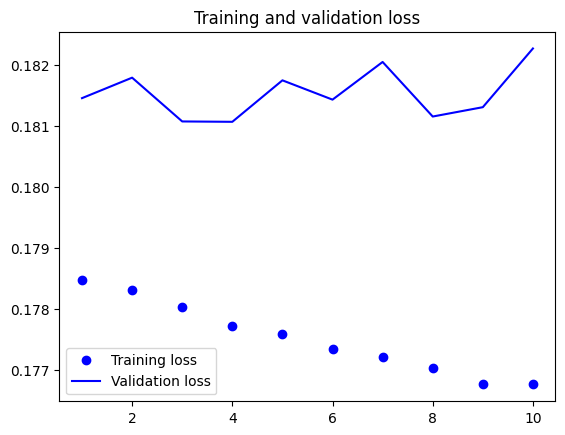

In [35]:
# get training and validation data
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1) # get number of epochs

# plot training and validation accuracy
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


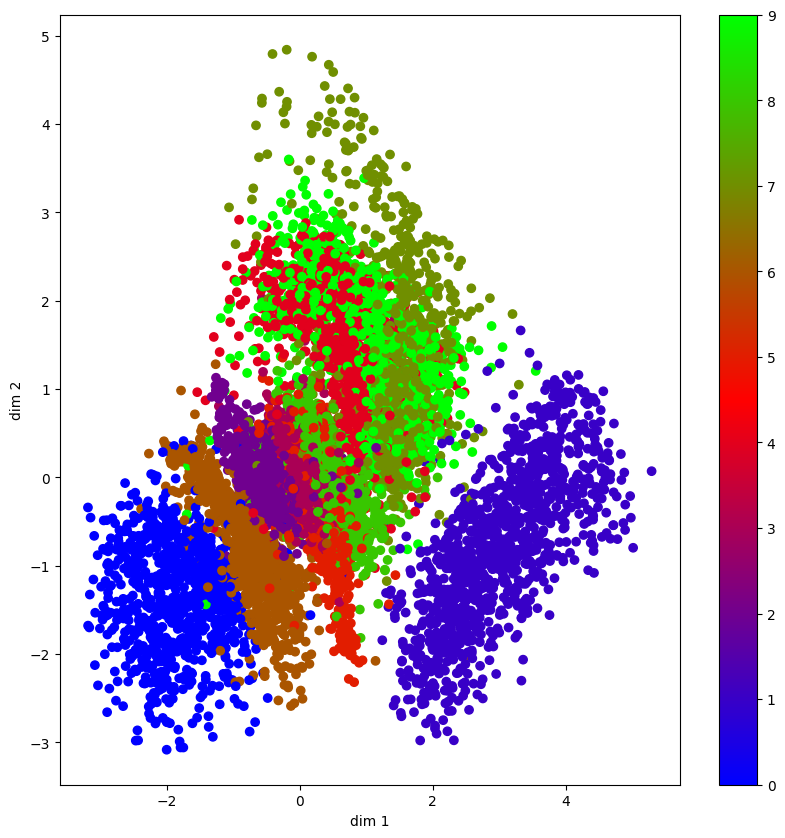

In [12]:
# CREATE FIGURE SHOWING THE LATENT VARIABLE SPACE

#Visualize inputs mapped to the Latent space
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

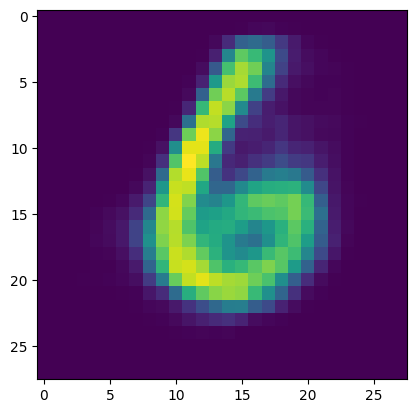

In [16]:
# Check a single decoded image

sample_vector = np.array([[-0.5,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

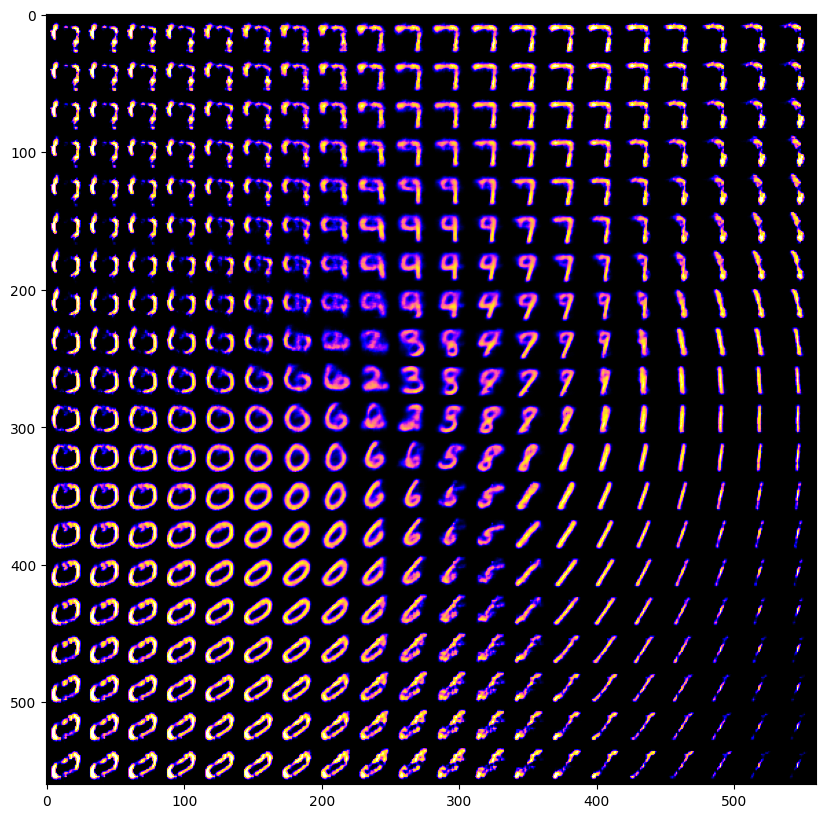

In [14]:
# CREATE A FIGURE SHOWING ALL THE VAE GENERATED IMAGES

# Take sample from some defined linear space. In this example range [-4, 4]
# Feed it to the decoder and update zeros in the figure with output.

# Define 20x20 figure
n = 20
figure = np.zeros((img_width * n, img_height * n, num_channels))

# Create a Grid of latent variables, to be provided as inputs to decoder.predict
# Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()